# Pentatonic Television: Predicting Future TV buyers
## _Exploratory Data Analysis Notebook_
## _Portfolio Project_
### _Author: Jean-Sebastien Provost_



--------------------

## Introduction


**Problem**:
A fictional electronic company called Pentatonic specialized into selling
high-end televisions. 

One day, Pentatonic bought a rival company, Meridian, which used to have an important part of the market. Since the merger occurred, we would like to target our new clients with a marketing campaign highlighting our new state-of-the-art television. Currently, we have access to the data of thousand of customers.

The goal of the project is to determine which customers should we target with our new campaign in order the increase our sales.

This project is divided into 5 sections:

    1.Data Exploration
    
        1.1 The Data

        1.2 Data Description & Preprocessing


    2.0 Some Data Visualization
         
         2.1 Distribution & Boxplots Plots
         
         2.2 Analysis For The Different Features
         
             2.2.1 Professions
         
             2.2.2 Cities
     
             2.2.3 Age Group
             
             2.2.4 Home Income
             
             2.2.5 Mixed Features
             
             
    3.0 Creating Train/Test Sets
    
    
    4.0 Extracting Feature Profiles From PCA Analysis
     
      


In [1]:
# Importing libraries
import numpy as np
import pandas as pd
from IPython.display import display
import seaborn as sns
from functools import reduce
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.decomposition import PCA

# To be able to view all of the columns when viewing the dataset
pd.options.display.max_columns = None

#  1. Exploratory Data Analysis
## 1.1 The Data

In [2]:
# Load the data
demo = pd.read_excel("data.xlsx", sheet_name="demographic_info")
customer = pd.read_excel("data.xlsx", sheet_name="customer_behavior")
interest = pd.read_excel("data.xlsx", sheet_name="interest_rate_info", dtype={"client_id": object})


In [3]:
datasets = {'demo': demo, 'customer': customer, 'interest': interest}

In [4]:
# Functions used in the rest of the project

def creating_distplot(size, df, features):
    '''
    Distribution plot for multiple features
    df: dataframe with the data
    features: Numerical features corresponding to colums in the dataframe
    Output: Produce n distribution plots according the to number of features provided in the list
    '''
    plt.figure(figsize=size)
    for i in range(len(features)):
        plt.subplot(5, 3, i+1)
        sns.distplot(df[features[i]])
        
def creating_boxplots(size, target, features, data):
    plt.figure(figsize=size)
    for i in range(len(numerical_vars)):
        plt.subplot(5, 3, i+1)
        sns.boxplot(x=target, y=features[i], data=data )
        
def log_transform(df, init_col, new_col):
    df[new_col] = np.log(df[init_col]+1)
    df = df.drop(init_col, axis=1)
    return(df)

def crossCorrelation(data):
    corr = data.corr()
    plt.figure(figsize=(10,6))
    sns.heatmap(corr, 
          xticklabels=corr.columns.values,
          yticklabels=corr.columns.values)
    print(corr)
    
def null_columns(df):
    return(pd.isnull(df).sum())

def drop_data_duplicates(df):
    print(df.duplicated().sum())
    df = df.drop_duplicates(inplace=True)
    return(df)

def get_unique(df, col):
    return(df[col].unique())

def change_values(df, feature, init_val, new_val, sign):
    '''''
    df: main dataframe for which we want to perform transformation
    feature: Targeted feature for which we want to do chnges in the values
    init_val: The initial value that we want to change
    new_val: The value that we want to replace with
    sign: The logical expression for the anonymous function; if the value is equal "==", 
        smaller "<", or greater ">" than the initial value
        
    '''''
    # Function definition
    if sign == "==":
        df[feature] = df[feature].apply(lambda x: new_val if x == init_val else x)
    
    if sign == '<':
        df[feature] = df[feature].apply(lambda x: new_val if x < init_val else x)
    
    elif sign == '>':
        df[feature] = df[feature].apply(lambda x: new_val if x > init_val else x)

## 1.2 Description Of The Data & Preprocessing

In [5]:
# Before merging the different datasets together, we want to assess if any missing values
# can be found in the different datasets
for k,v in datasets.items():
    print("The dataset {} has {} rows and {} columns".format(k, v.shape[0], v.shape[1]))
    print(null_columns(v),'\n')


The dataset demo has 20510 rows and 11 columns
client_id           10
english              0
birth_last_year      0
apartment            0
job_title            0
nb_children          0
city                 0
education            0
age                  0
income               0
household_income     0
dtype: int64 

The dataset customer has 20490 rows and 18 columns
client_id                        0
visit the store_last_year        0
premium_membership               0
credit_card                      0
web_search                      30
nb_web_search                   30
membership_competitors           0
won_prize                        0
required_financing               0
cash_transaction                 0
nb_product_purchased             0
customer_since_when              0
volume_credit_card           12199
prize_amount                 12199
volume_financing                 0
volume_transaction            1013
nb_electronics                   0
purchased                        0
dtyp

From the output above, we can observe that we have missing data: 
- 60% 'volume_credit_card'
- 60% 'prize_amount'
- 5%  'volume_transaction'

We will verify if these clients have products related to these categories before removing/imputing them.
If a client does not possess an active credit card, it is logical that this client will not have any volume.

In [6]:
# Extract the number of clients with a credit card and volume is NA
print('Number of missing credit card volume:', customer[customer['volume_credit_card'].isna()].shape[0])
print('Clients with credit card and missing volume: {}\n'.format(customer[customer['volume_credit_card'].isna()]['credit_card'].sum()))

# Extract the number of clients with a credit card and volume is NA
print('Number of missing prize amount:', customer[customer['prize_amount'].isna()].shape[0])
print('Clients with a won prize and missing volume: {}\n'.format(customer[customer['prize_amount'].isna()]['won_prize'].sum()))

# Extract the number of clients with a credit card and volume is NA
print('Number of missing transactions:', customer[customer['volume_transaction'].isna()].shape[0])
print('Clients with volume of transactions and missing volume: {}\n'.format(customer[customer['volume_transaction'].isna()]['cash_transaction'].sum()))

Number of missing credit card volume: 12199
Clients with credit card and missing volume: 0

Number of missing prize amount: 12199
Clients with a won prize and missing volume: 4235

Number of missing transactions: 1013
Clients with volume of transactions and missing volume: 0



In [7]:
# Imputing the missing values for the volumes with 0
cols = ['volume_credit_card', 'prize_amount', 'volume_transaction']
customer[cols] = customer[cols].fillna(0)

### Merging of the different datasets to create one main dataframe


In [8]:
# We will now merge the different datasets on the two commom features, namely 'month', and 'CLIENT_ID'.
# We will print the dimensions of the new dataset as a sanity check
main_df = reduce(lambda left, right: pd.merge(left, right, on='client_id'), [demo, customer, interest])
main_df.shape

(23084, 30)

In [9]:
print('Number of duplicated clients:', main_df['client_id'].duplicated().sum())
main_df = main_df[~main_df['client_id'].duplicated()]
main_df = main_df.reset_index(drop=True)

Number of duplicated clients: 3046


In [10]:
main_df.describe()

,english,birth_last_year,apartment,job_title,nb_children,city,education,age,income,household_income,visit the store_last_year,premium_membership,credit_card,web_search,nb_web_search,membership_competitors,won_prize,required_financing,cash_transaction,nb_product_purchased,customer_since_when,volume_credit_card,prize_amount,volume_financing,volume_transaction,nb_electronics,purchased,interest_rate,GDP
count,20038.000000,20038.000000,20038.000000,20038.000000,20038.000000,20038.000000,20038.000000,20038.000000,2.003800e+04,2.003800e+04,20038.000000,20038.000000,20038.000000,20015.000000,20015.000000,20038.000000,20038.000000,20038.000000,20038.000000,20038.000000,20038.000000,20038.000000,20038.000000,20038.000000,20038.000000,20038.000000,20038.000000,20015.000000,20015.000000
mean,0.595968,0.205210,0.295838,2.808115,1.039625,4.165835,2.700369,64.405629,6.029484e+04,1.350252e+05,0.091127,0.249676,0.404382,0.355733,9.863053,0.350534,0.347440,0.248478,0.950344,1.811857,7.400412,7115.882675,0.749040,6289.178007,1918.485877,0.413764,0.100359,2.851087,0.493137
std,0.490716,0.403865,0.456430,1.579255,2.626246,1.753883,1.513048,113.576990,3.200494e+04,7.751636e+04,0.364875,0.432836,0.490784,0.514950,15.888960,0.477149,0.476169,0.432141,0.217238,0.875738,4.527617,10137.253292,1.067079,13313.030758,1099.267821,0.492519,0.300486,0.356129,1.041874
min,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,19.000000,1.000000e+04,1.500000e+04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.240305,-3.631180
25%,0.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,37.000000,4.600000e+04,7.700000e+04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,5.090909,0.000000,0.000000,0.000000,1200.000000,0.000000,0.000000,2.601974,-0.204602
50%,1.000000,0.000000,0.000000,2.000000,0.000000,5.000000,3.000000,50.000000,6.000000e+04,1.200000e+05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2.000000,7.272727,0.000000,0.000000,0.000000,1940.000000,0.000000,0.000000,2.782025,0.493018
75%,1.000000,0.000000,1.000000,4.000000,2.000000,6.000000,4.000000,64.000000,7.300000e+04,1.820000e+05,0.000000,0.000000,1.000000,1.000000,19.000000,1.000000,1.000000,0.000000,1.000000,2.000000,9.454545,16048.888889,1.689357,0.000000,2630.000000,1.000000,0.000000,3.028168,1.198330
max,1.000000,1.000000,1.000000,6.000000,99.000000,6.000000,5.000000,999.000000,1.132000e+06,1.455000e+06,9.000000,1.000000,1.000000,9.000000,45.000000,1.000000,1.000000,1.000000,1.000000,13.000000,95.272727,115664.444444,12.175205,249407.608657,16050.000000,1.000000,1.000000,4.979926,4.632917


After inspection, some unusual values can be observed in some columns. They are listed below:

    - Nb_children: max=99
    - age: max = older than=101, but we have values going from 101 to 999
    - customer_since_when: max=95
   


### We can assume errors during data entry or code identifying missing values. Unfortunately we cannot verify our intuition; most likely these values indique missing entries.

In [11]:
# Extracting the unique values for these features
variables = ['nb_children', 'age', 'customer_since_when']

# Printing the different levels of each feature
for variable in variables:
    print(variable, get_unique(main_df, variable))

nb_children [ 4  0  2  1  3  5  6 99  7]
age [ 36  53  42  68  75  45  67  55  43  59  48  62  56  26  40  70  41  44
  51  69  52  88  20  63  61  65  74  27  60 999  28  77  31  19  33  29
  57  66  49  82  73  46  54  79  58  32  71 211  39  38  80  78  64  47
  50  25  24  37  34  89  35  86  30  87  90 208  85  23  83  76 218  72
 204  81  21  22  84 214 101 206 226 203 202 209 207 215 228 219 213 222
 205 220 212 234 221 225]
customer_since_when [10.18181818  8.72727273  4.36363636  5.09090909  6.54545455  7.27272727
  0.          2.90909091  5.81818182  8.         93.09090909 11.63636364
 13.09090909  9.45454545 15.27272727  2.18181818  3.63636364 12.36363636
 10.90909091 14.54545455  0.72727273  1.45454545 13.81818182 16.72727273
 16.         17.45454545 91.63636364 18.18181818 92.36363636 95.27272727
 93.81818182]


### For the nb_children feature, we have a value of 99 which is out of range.

### For age, we have some clients older than 101, which is plausible; however we have other clients older than 200.

### Finally, we have clients who have been customer for the store company for more than 95 years which is implausible.

### Consequently, we will replace these values by NaN.


In [12]:
lst = [[main_df, 'nb_children', 99, np.nan, '=='],
      [main_df, 'age', 102, np.nan, '>'],
      [main_df, 'customer_since_when', 50, np.nan, '>']]

# Loop to apply the function 'change_values' replacing the unusual values with NaNs as prescribed above.
for elem in lst:
    change_values(elem[0], elem[1], elem[2], elem[3], elem[4],)

In [13]:
# Sanity check following the imputation
main_df.describe()

,english,birth_last_year,apartment,job_title,nb_children,city,education,age,income,household_income,visit the store_last_year,premium_membership,credit_card,web_search,nb_web_search,membership_competitors,won_prize,required_financing,cash_transaction,nb_product_purchased,customer_since_when,volume_credit_card,prize_amount,volume_financing,volume_transaction,nb_electronics,purchased,interest_rate,GDP
count,20038.000000,20038.000000,20038.000000,20038.000000,20028.000000,20038.000000,20038.000000,19637.000000,2.003800e+04,2.003800e+04,20038.000000,20038.000000,20038.000000,20015.000000,20015.000000,20038.000000,20038.000000,20038.000000,20038.000000,20038.000000,20016.000000,20038.000000,20038.000000,20038.000000,20038.000000,20038.000000,20038.000000,20015.000000,20015.000000
mean,0.595968,0.205210,0.295838,2.808115,0.990713,4.165835,2.700369,50.108774,6.029484e+04,1.350252e+05,0.091127,0.249676,0.404382,0.355733,9.863053,0.350534,0.347440,0.248478,0.950344,1.811857,7.307027,7115.882675,0.749040,6289.178007,1918.485877,0.413764,0.100359,2.851087,0.493137
std,0.490716,0.403865,0.456430,1.579255,1.451403,1.753883,1.513048,16.963707,3.200494e+04,7.751636e+04,0.364875,0.432836,0.490784,0.514950,15.888960,0.477149,0.476169,0.432141,0.217238,0.875738,3.546485,10137.253292,1.067079,13313.030758,1099.267821,0.492519,0.300486,0.356129,1.041874
min,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,19.000000,1.000000e+04,1.500000e+04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.240305,-3.631180
25%,0.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,36.000000,4.600000e+04,7.700000e+04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,5.090909,0.000000,0.000000,0.000000,1200.000000,0.000000,0.000000,2.601974,-0.204602
50%,1.000000,0.000000,0.000000,2.000000,0.000000,5.000000,3.000000,49.000000,6.000000e+04,1.200000e+05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2.000000,7.272727,0.000000,0.000000,0.000000,1940.000000,0.000000,0.000000,2.782025,0.493018
75%,1.000000,0.000000,1.000000,4.000000,2.000000,6.000000,4.000000,63.000000,7.300000e+04,1.820000e+05,0.000000,0.000000,1.000000,1.000000,19.000000,1.000000,1.000000,0.000000,1.000000,2.000000,9.454545,16048.888889,1.689357,0.000000,2630.000000,1.000000,0.000000,3.028168,1.198330
max,1.000000,1.000000,1.000000,6.000000,7.000000,6.000000,5.000000,101.000000,1.132000e+06,1.455000e+06,9.000000,1.000000,1.000000,9.000000,45.000000,1.000000,1.000000,1.000000,1.000000,13.000000,18.181818,115664.444444,12.175205,249407.608657,16050.000000,1.000000,1.000000,4.979926,4.632917


In [14]:
# Table to identify missing values and their features
pd.isnull(main_df).sum()

client_id                      0
english                        0
birth_last_year                0
apartment                      0
job_title                      0
nb_children                   10
city                           0
education                      0
age                          401
income                         0
household_income               0
visit the store_last_year      0
premium_membership             0
credit_card                    0
web_search                    23
nb_web_search                 23
membership_competitors         0
won_prize                      0
required_financing             0
cash_transaction               0
nb_product_purchased           0
customer_since_when           22
volume_credit_card             0
prize_amount                   0
volume_financing               0
volume_transaction             0
nb_electronics                 0
purchased                      0
interest_rate                 23
GDP                           23
dtype: int

In [15]:
# Fill in the missing value with the median
fill_median = ['age', 'nb_children', 'customer_since_when']
main_df[fill_median] = main_df[fill_median].fillna(main_df.median())


### Finally, we have missing values in :
- 23 observations for the feature web_search
- 23 observations for the feature nb_web_search
- 23 observations for interest_rate
- 23 observations for the GDP

Since these observations represent a small subset of the data set, we will remove these observations.

In [16]:
# Removing the observations for the missing values corresponding to the 3 features sex, web, previous_loan
main_df = main_df.dropna(subset=['web_search', 'nb_web_search', 'interest_rate', 'GDP'])


# 2. Exploratory Data Analysis

In [17]:
#Re-encoding of the categorical features
main_df['education_cat'] = ['high_school' if x==1 
                        else 'college' if x==2
                        else 'undergradute' if x==3
                        else 'master_degree' if x==4
                        else 'doctorate_degree'
                        for x in main_df['education']]

main_df['city_cat'] = ['Oakland' if x==1 
                        else 'Sonoma' if x==2
                        else 'Redwood' if x==3
                        else 'Berkeley' if x==4
                        else 'Sacramento' if x==5
                        else 'San Francisco'
                        for x in main_df['city']]

main_df['job_title_cat'] = ['professional' if x==1 
                        else 'manager' if x==2
                        else 'blue collar' if x==3
                        else 'white collar' if x==4
                        else 'retired' if x==5
                        else 'unemployed'
                        for x in main_df['job_title']]

main_df.drop(['job_title', 'education', 'city'], axis=1, inplace=True)

<ipython-input-17-ab2e902a9e69>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  main_df['education_cat'] = ['high_school' if x==1
<ipython-input-17-ab2e902a9e69>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  main_df['city_cat'] = ['Oakland' if x==1
<ipython-input-17-ab2e902a9e69>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

In [18]:
# Creation de listes pour le processing des données/variables
categorical_vars = ['job_title_cat', 'city_cat', 'education_cat']

binary_vars = ['english', 'birth_last_year', 'apartment', 'visit the store_last_year', 'premium_membership',
               'credit_card', 'web_search', 'membership_competitors', 'won_prize', 'required_financing',
               'cash_transaction', 'purchased'
              ]

numerical_vars = ['nb_children', 'age', 'income', 'household_income', 'nb_web_search', 'nb_product_purchased',
                  'customer_since_when', 'volume_credit_card', 'prize_amount', 'volume_financing',
                  'volume_transaction', 'nb_electronics', 'interest_rate', 'GDP'
                 ]


## 2.1 Distribution & Boxplots Plots

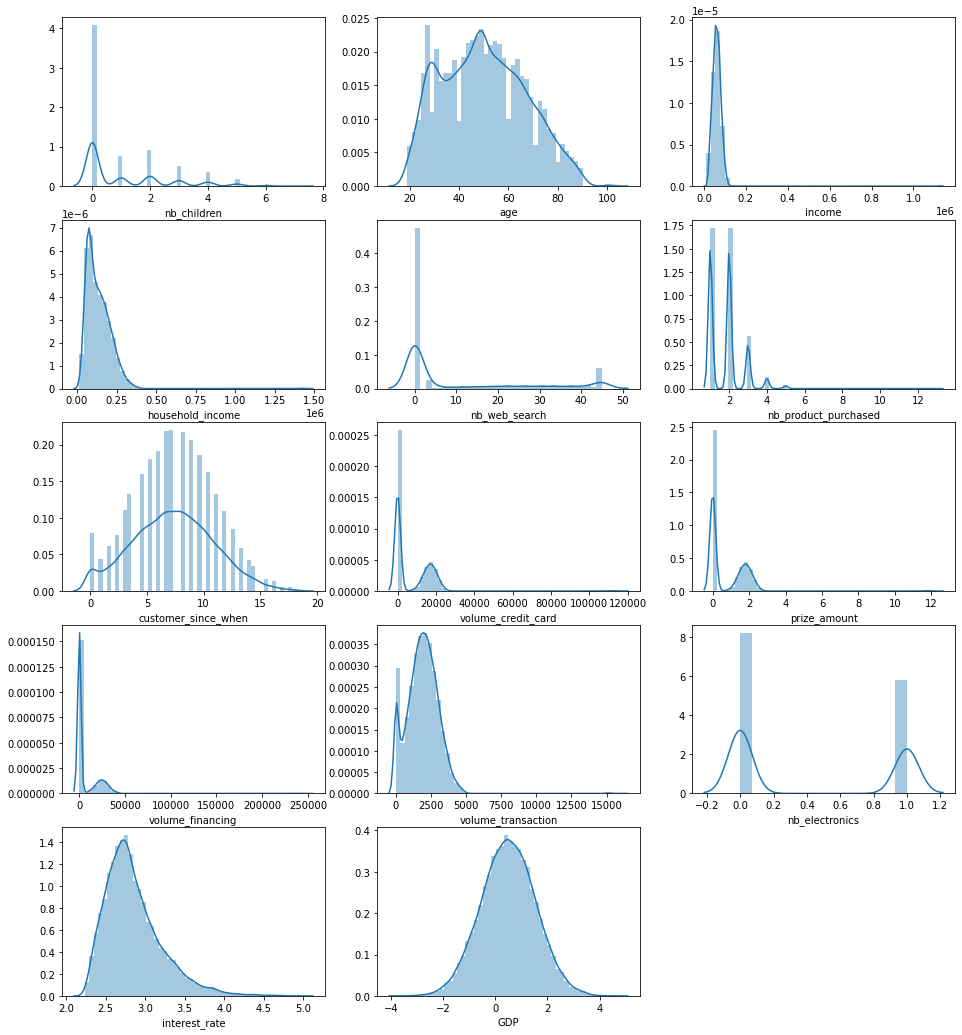

In [19]:
# Figures pour observer la distribution des différentes variables numériques
creating_distplot((16,18), main_df, numerical_vars)


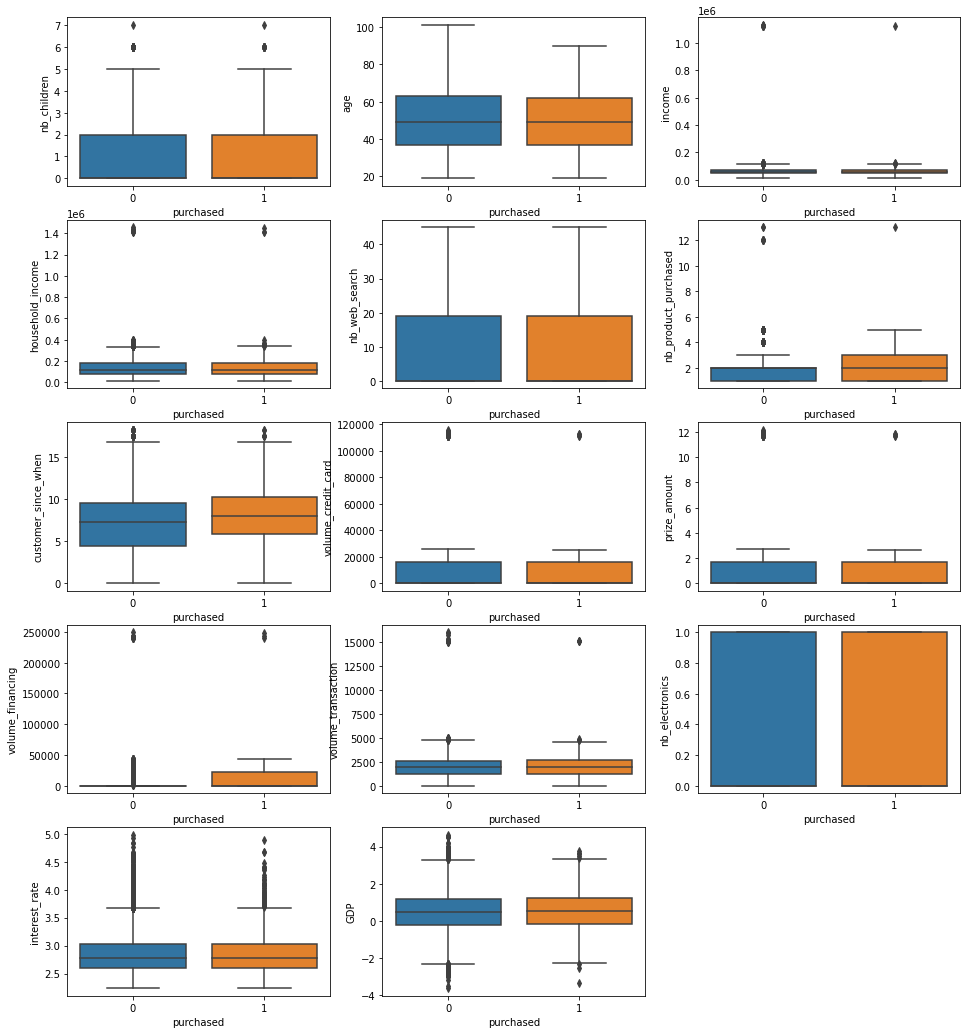

In [20]:
# size, target, features, data)
creating_boxplots((16,18), 'purchased', numerical_vars, main_df)

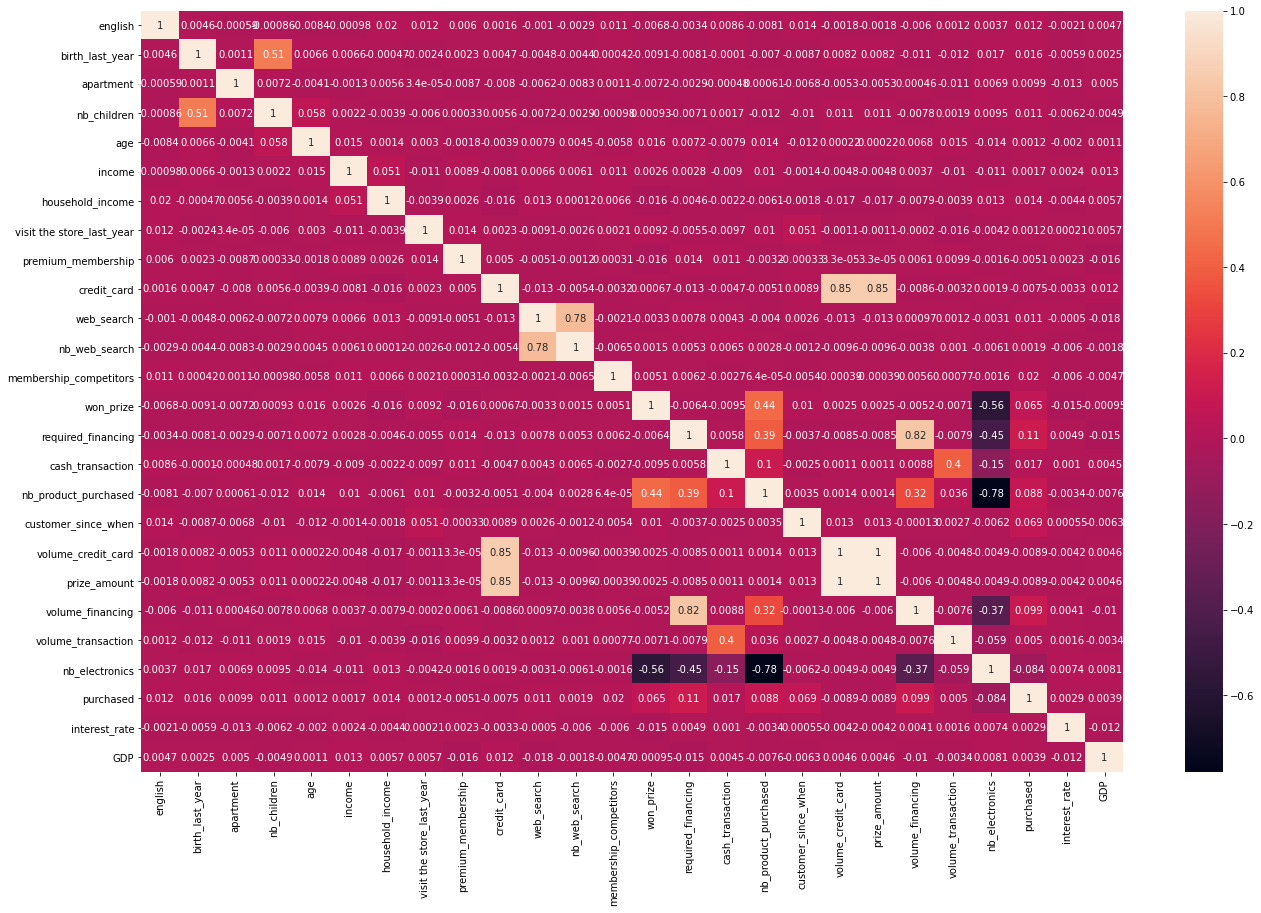

In [21]:
corrMatrix = main_df.corr()
plt.figure(figsize=(22,14))
sns.heatmap(corrMatrix, annot=True)
plt.show()

We can observe some interesting correlations from the figure above. With respect to our target feature 'PURCHASED', we have light correlations with:
   
   - required_financing
   - nb_product_purchased
   - volume_financing
   - nb_electronics.

However, we also observe correlations between some of the independent variables which could affect a future linear model from multicollinearity.

Let's look at the distribution of the numerical features and how it is affected by the target feature.

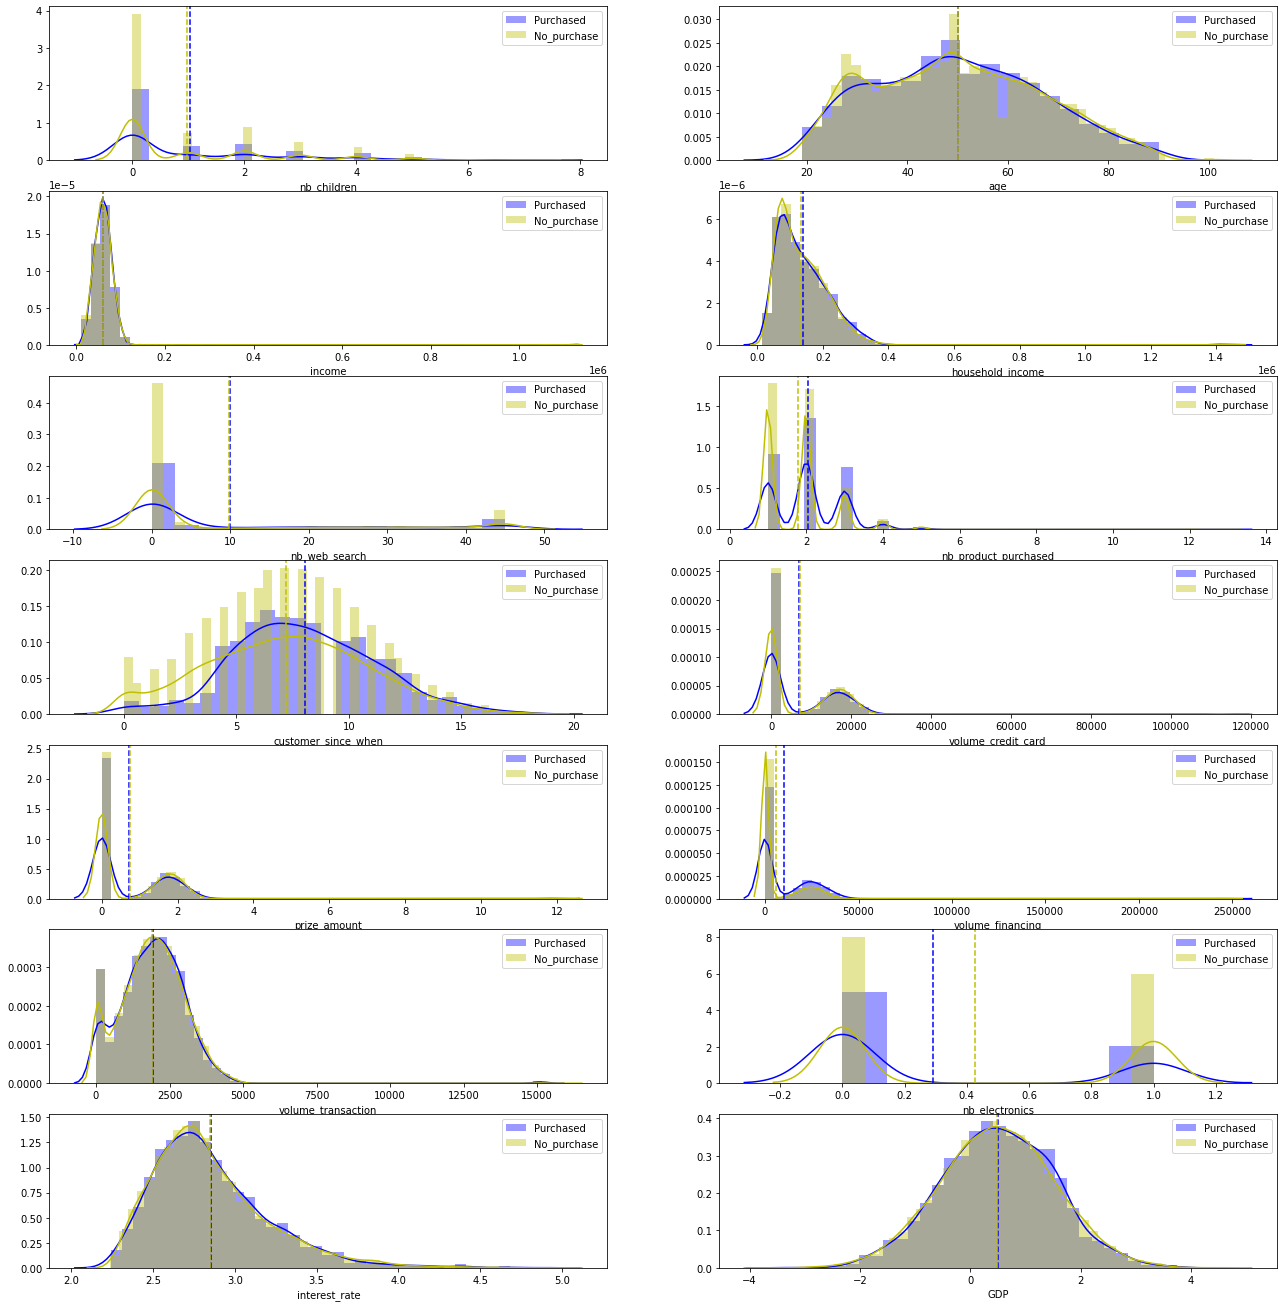

In [22]:
# Subsetting by whether a PH was given or not
purchased = main_df["purchased"] == 1
no_purchase = main_df["purchased"] == 0

# Creating the plots
labels = ["Purchased", "No_purchase"]

def distribution_plots(features, labels):
    plt.figure(figsize=(22,30))
    for feature in features:
        plt.subplot(9, 2, features.index(feature)+1)
        sns.distplot(main_df[feature][purchased], label=labels[0], color="b")
        sns.distplot(main_df[feature][no_purchase], label=labels[1], color="y")
        plt.axvline(main_df[feature][purchased].mean(), linestyle = '--', color="b")
        plt.axvline(main_df[feature][no_purchase].mean(), linestyle = '--', color="y")
        plt.legend()

distribution_plots(numerical_vars, labels)

There is not a lot of difference between the distribution of the customers who have bought a television and those who didn't with respect to the different features.

In [131]:
main_df.describe()

,index,english,birth_last_year,apartment,nb_children,age,income,household_income,visit the store_last_year,premium_membership,credit_card,web_search,nb_web_search,membership_competitors,won_prize,required_financing,cash_transaction,nb_product_purchased,customer_since_when,volume_credit_card,prize_amount,volume_financing,volume_transaction,nb_electronics,purchased,interest_rate,GDP
count,20015.000000,20015.000000,20015.000000,20015.000000,20015.000000,20015.000000,2.001500e+04,2.001500e+04,20015.000000,20015.000000,20015.000000,20015.000000,20015.000000,20015.000000,20015.000000,20015.000000,20015.000000,20015.000000,20015.000000,20015.000000,20015.000000,20015.000000,20015.000000,20015.000000,20015.000000,20015.000000,20015.000000
mean,10973.799201,0.595953,0.205046,0.295828,0.989958,50.087484,6.031312e+04,1.350629e+05,0.091182,0.249713,0.404297,0.355733,9.863053,0.350487,0.347489,0.248364,0.950337,1.812041,7.306338,7114.102738,0.748853,6286.742280,1918.100924,0.413740,0.100475,2.851087,0.493137
std,6640.887869,0.490719,0.403745,0.456426,1.451267,16.792900,3.200360e+04,7.750398e+04,0.365016,0.432858,0.490768,0.514950,15.888960,0.477134,0.476185,0.432075,0.217253,0.875961,3.544176,10137.965728,1.067154,13314.333640,1099.411484,0.492515,0.300639,0.356129,1.041874
min,0.000000,0.000000,0.000000,0.000000,0.000000,19.000000,1.000000e+04,1.500000e+04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.240305,-3.631180
25%,5188.500000,0.000000,0.000000,0.000000,0.000000,37.000000,4.600000e+04,7.700000e+04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,5.090909,0.000000,0.000000,0.000000,1200.000000,0.000000,0.000000,2.601974,-0.204602
50%,10627.000000,1.000000,0.000000,0.000000,0.000000,49.000000,6.000000e+04,1.200000e+05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2.000000,7.272727,0.000000,0.000000,0.000000,1930.000000,0.000000,0.000000,2.782025,0.493018
75%,16638.500000,1.000000,0.000000,1.000000,2.000000,62.000000,7.300000e+04,1.820000e+05,0.000000,0.000000,1.000000,1.000000,19.000000,1.000000,1.000000,0.000000,1.000000,2.000000,9.454545,16044.629630,1.688908,0.000000,2630.000000,1.000000,0.000000,3.028168,1.198330
max,23060.000000,1.000000,1.000000,1.000000,7.000000,101.000000,1.132000e+06,1.455000e+06,9.000000,1.000000,1.000000,9.000000,45.000000,1.000000,1.000000,1.000000,1.000000,13.000000,18.181818,115664.444444,12.175205,249407.608657,16050.000000,1.000000,1.000000,4.979926,4.632917


## 2.2 Analysis For The Different Features

In [23]:
# Extracting the median to see how it compares with the mean for the entire data set.
for i in numerical_vars:
    print(i, main_df[i].median())

nb_children 0.0
age 49.0
income 60000.0
household_income 120000.0
nb_web_search 0.0
nb_product_purchased 2.0
customer_since_when 7.2727272727272725
volume_credit_card 0.0
prize_amount 0.0
volume_financing 0.0
volume_transaction 1930.0
nb_electronics 0.0
interest_rate 2.782025180242056
GDP 0.49301798216388015


In [24]:
main_df[main_df['purchased'] == 1].describe()

,english,birth_last_year,apartment,nb_children,age,income,household_income,visit the store_last_year,premium_membership,credit_card,web_search,nb_web_search,membership_competitors,won_prize,required_financing,cash_transaction,nb_product_purchased,customer_since_when,volume_credit_card,prize_amount,volume_financing,volume_transaction,nb_electronics,purchased,interest_rate,GDP
count,2011.000000,2011.000000,2011.000000,2011.000000,2011.000000,2.011000e+03,2.011000e+03,2011.000000,2011.000000,2011.000000,2011.000000,2011.000000,2011.000000,2011.000000,2011.000000,2011.000000,2011.000000,2011.000000,2011.000000,2011.000000,2011.000000,2011.000000,2011.000000,2011.0,2011.000000,2011.000000
mean,0.613128,0.224267,0.309299,1.038289,50.146196,6.047290e+04,1.382456e+05,0.092491,0.243163,0.393337,0.371954,9.955246,0.378419,0.440577,0.392839,0.961213,2.042765,8.036526,6843.937050,0.720414,10214.337448,1934.624565,0.290403,1.0,2.854135,0.505193
std,0.487155,0.417202,0.462320,1.491277,16.580799,3.076961e+04,8.804479e+04,0.346120,0.429099,0.488612,0.519174,15.691744,0.485113,0.496580,0.488503,0.193134,0.888938,3.152625,9734.365753,1.024670,15978.206306,1171.666711,0.454061,0.0,0.354492,1.009369
min,0.000000,0.000000,0.000000,0.000000,19.000000,1.000000e+04,1.500000e+04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,2.242292,-3.358127
25%,0.000000,0.000000,0.000000,0.000000,37.000000,4.700000e+04,7.700000e+04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,5.818182,0.000000,0.000000,0.000000,1230.000000,0.000000,1.0,2.604440,-0.190607
50%,1.000000,0.000000,0.000000,0.000000,49.000000,6.000000e+04,1.210000e+05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2.000000,8.000000,0.000000,0.000000,0.000000,1970.000000,0.000000,1.0,2.787245,0.503074
75%,1.000000,0.000000,1.000000,2.000000,62.000000,7.300000e+04,1.835000e+05,0.000000,0.000000,1.000000,1.000000,19.000000,1.000000,1.000000,1.000000,1.000000,3.000000,10.181818,15793.333333,1.662456,22426.630433,2640.000000,1.000000,1.0,3.033111,1.224833
max,1.000000,1.000000,1.000000,7.000000,90.000000,1.125000e+06,1.453000e+06,9.000000,1.000000,1.000000,9.000000,45.000000,1.000000,1.000000,1.000000,1.000000,13.000000,18.181818,112810.740741,11.874815,249114.130396,15180.000000,1.000000,1.0,4.887411,3.753455


In [25]:
# Extracting the median to see how it compares with the mean only for the clients who converted.
for i in numerical_vars:
    print(i, main_df[main_df['purchased'] == 1][i].median())

nb_children 0.0
age 49.0
income 60000.0
household_income 121000.0
nb_web_search 0.0
nb_product_purchased 2.0
customer_since_when 8.0
volume_credit_card 0.0
prize_amount 0.0
volume_financing 0.0
volume_transaction 1970.0
nb_electronics 0.0
interest_rate 2.7872453856170427
GDP 0.5030738115591447


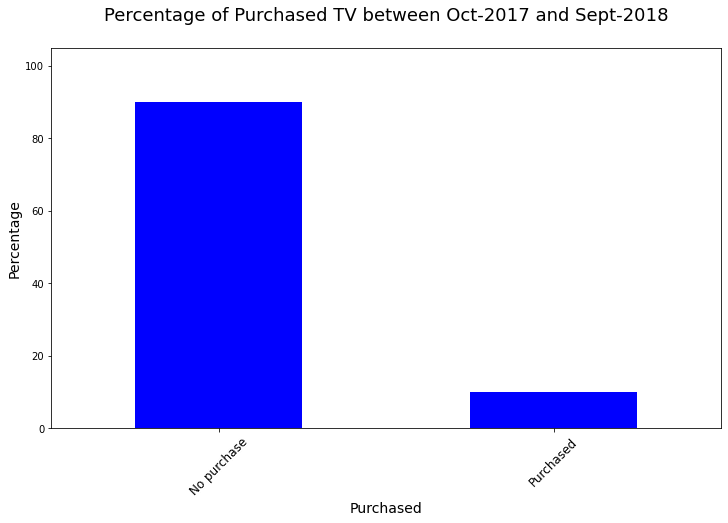

In [26]:
mortgages_df = pd.DataFrame(main_df.groupby('purchased')['client_id'].count()/len(main_df)*100)
values = ['No purchase', 'Purchased']

ax = mortgages_df.plot(
    kind='bar',
    color='blue',
    figsize=(12,7))
ax.set_xlabel('Purchased', fontsize=14)
ax.set_ylabel('Percentage', fontsize=14)
ax.get_legend().remove()
ax.set_title('Percentage of Purchased TV between Oct-2017 and Sept-2018\n', fontsize=18)
plt.xticks(mortgages_df.index,values, rotation=45, fontsize=12)
ax.set_ylim(0,105)
plt.show()

### 2.2.1 Professions

      job_title  %Purchased  %All Clients  ratio
0       manager        31.0          31.0   1.00
1  professional        22.0          22.0   1.00
2   blue collar        18.0          19.0   0.95
3  white collar        11.0          11.0   1.00
4    unemployed        11.0          11.0   1.00
5       retired         7.0           7.0   1.00


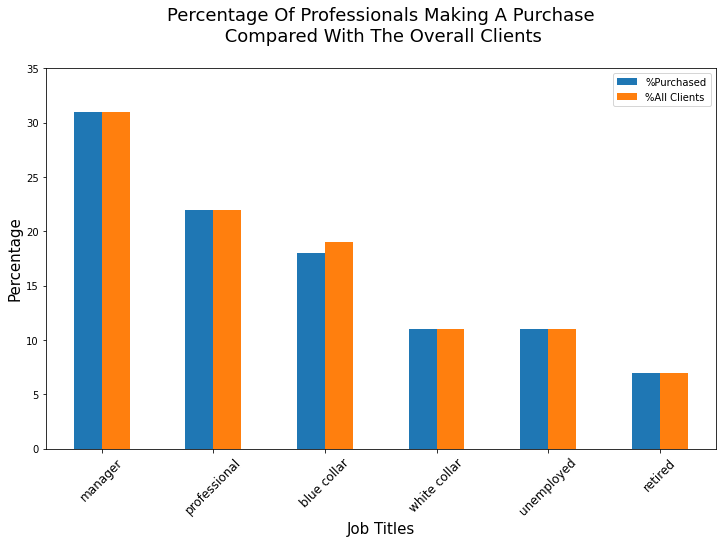

In [27]:
# Table of percentage of purchased based on profession
group_purchased = main_df[main_df['purchased']==1]

group_purchased = pd.DataFrame(round(group_purchased.job_title_cat.value_counts()/len(group_purchased)*100,0)).reset_index()
group_all = pd.DataFrame(round(main_df.job_title_cat.value_counts()/len(main_df)*100,0)).reset_index()

group_merge = pd.merge(group_purchased, group_all, how='inner', on='index')
group_merge
group_merge = group_merge.rename(columns={"job_title_cat_x":'%Purchased', "job_title_cat_y":'%All Clients', "index":'job_title' })
group_merge['ratio'] = round(group_merge["%Purchased"]/group_merge['%All Clients'],2)
print(group_merge)

ax = group_merge[['job_title', '%Purchased', '%All Clients']].plot(
    kind='bar',
    figsize=(12,7)
    )
ax.set_xticklabels(group_merge['job_title'], rotation=45, fontsize=12)
ax.set_ylabel('Percentage', fontsize = 15)
ax.set_xlabel('Job Titles', fontsize=15)
ax.set_ylim(0,35)
ax.set_title('Percentage Of Professionals Making A Purchase\n Compared With The Overall Clients\n', fontsize=18)
plt.show()

### 2.2.2 Cities

            city  %Purchased  %All Clients  ratio
0  San Francisco        33.0          31.0   1.06
1     Sacramento        20.0          20.0   1.00
2       Berkeley        16.0          16.0   1.00
3        Oakland        13.0          14.0   0.93
4        Redwood        12.0          11.0   1.09
5         Sonoma         7.0           7.0   1.00


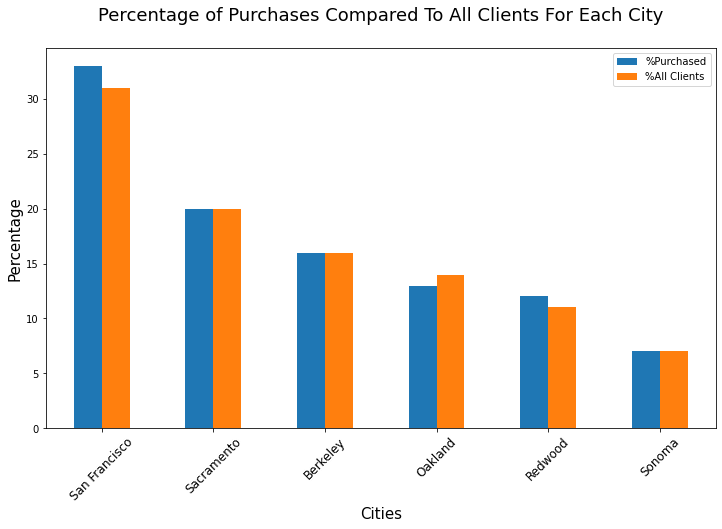

In [28]:
# Table of percentage of loan based on city they are living in
group_purchased = main_df[main_df['purchased']==1]

group_purchased = pd.DataFrame(round(group_purchased.city_cat.value_counts()/len(group_purchased)*100,0)).reset_index()
group_all = pd.DataFrame(round(main_df.city_cat.value_counts()/len(main_df)*100,0)).reset_index()

group_merge = pd.merge(group_purchased, group_all, how='inner', on='index')

group_merge = group_merge.rename(columns={"city_cat_x":'%Purchased', "city_cat_y":'%All Clients', "index":'city' })
group_merge['ratio'] = round(group_merge["%Purchased"]/group_merge['%All Clients'],2)

print(group_merge)

ax = group_merge[['city', '%Purchased', '%All Clients']].plot(
    kind='bar',
    figsize=(12,7)
    )
ax.set_xticklabels(group_merge['city'], rotation=45, fontsize=12)
ax.set_title('Percentage of Purchases Compared To All Clients For Each City\n', fontsize=18)
ax.set_ylabel('Percentage', fontsize=15)
ax.set_xlabel('Cities', fontsize=15)
plt.show()

In [30]:
tmp = main_df.copy()
tmp['conversion'] = tmp['purchased']
purchased_city = pd.pivot_table(tmp, values='conversion', index='city_cat', columns='purchased', aggfunc=len)
purchased_city['%Purchased'] = round(purchased_city[1]/(purchased_city[0] + purchased_city[1])*100,1)
purchased_city

purchased,0,1,%Purchased
city_cat,,,
Berkeley,2903,323,10.0
Oakland,2484,260,9.5
Redwood,1915,233,10.8
Sacramento,3705,395,9.6
San Francisco,5643,654,10.4
Sonoma,1354,146,9.7


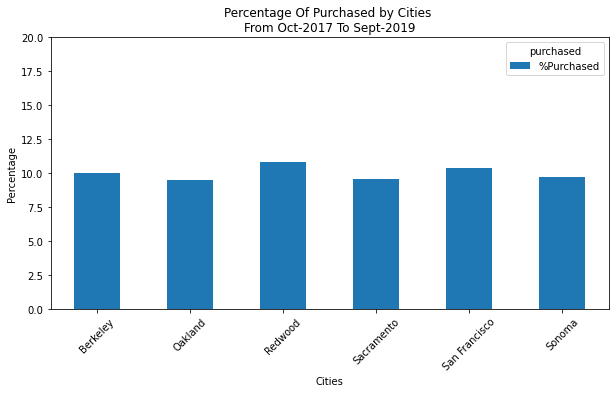

In [31]:
# Percentage of TV purchasd per city
ax = purchased_city.reset_index()[['city_cat', '%Purchased']].plot(
    kind='bar',
    figsize=(10,5),
    title='Percentage Of Purchased by Cities \nFrom Oct-2017 To Sept-2019')
ax.set_xlabel('Cities')
ax.set_ylabel('Percentage')
ax.set_ylim(0, 20)
ax.set_xticklabels(purchased_city.index, rotation=45)
plt.show()

In [32]:
by_city_df = main_df[main_df['purchased'] == 1]     \
                    .groupby([                  \
                            'city_cat', 'job_title_cat'    \
                            ]).count()['client_id']/main_df.groupby('city_cat').count()['client_id']*100

by_city_df = by_city_df.unstack().fillna(0)
by_city_df

job_title_cat,blue collar,manager,professional,retired,unemployed,white collar
city_cat,,,,,,
Berkeley,1.611903,3.688779,2.200868,0.371978,1.022939,1.115933
Oakland,1.895044,2.660350,2.077259,0.655977,1.056851,1.129738
Redwood,1.955307,3.538175,2.001862,0.605214,1.582868,1.163873
Sacramento,1.609756,3.000000,2.341463,0.804878,1.000000,0.878049
San Francisco,1.842147,3.096713,2.382087,0.730507,1.079879,1.254566
Sonoma,1.933333,2.533333,1.666667,1.066667,1.066667,1.466667


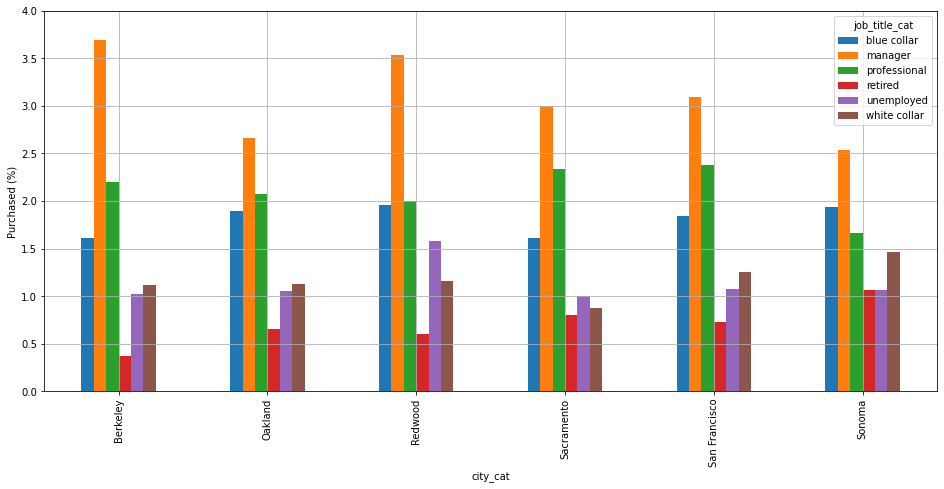

In [33]:
# Create a visualization
ax = by_city_df.plot(
    kind='bar',
    figsize=(16, 7),
    grid=True
)
ax.set_ylabel('Purchased (%)')
ax.set_ylim(0,4)

plt.show()

### 2.2.3 Age Group

In [34]:
# Creating age group
main_df['age_group'] = main_df['age'].apply(lambda x : '[18, 30]' if x < 30
                          else '[30, 40]' if x < 40 
                          else '[40, 50]' if x < 50
                          else '[50, 60]' if x < 60
                          else '[60, 70]' if x < 70
                          else '70+')

purchased_by_age_group = main_df.groupby(by='age_group')['purchased'].sum()/main_df.groupby(by='age_group')['purchased'].count()*100
purchased_by_age_group

<ipython-input-34-877bb073ea46>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  main_df['age_group'] = main_df['age'].apply(lambda x : '[18, 30]' if x < 30


age_group
70+          9.543568
[18, 30]     9.506531
[30, 40]     9.872710
[40, 50]    10.305433
[50, 60]    10.450161
[60, 70]    10.336000
Name: purchased, dtype: float64

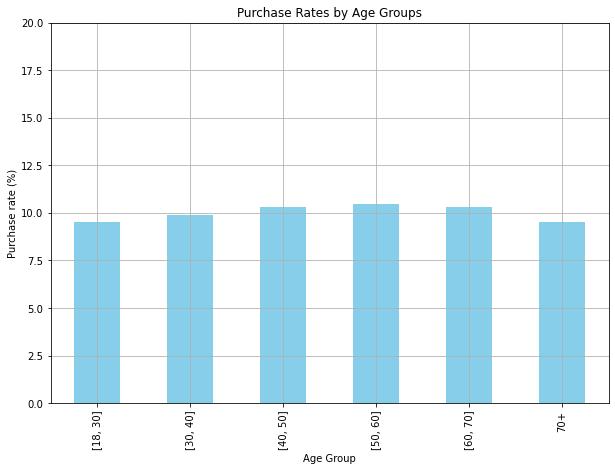

In [35]:
col = ['[18, 30]', '[30, 40]', '[40, 50]', '[50, 60]', '[60, 70]', '70+']
ax = purchased_by_age_group.loc[col
].plot(
    kind='bar',
    color='skyblue',
    grid=True,
    figsize=(10, 7),
    title='Purchase Rates by Age Groups'
)
ax.set_xlabel('Age Group')
ax.set_ylabel('Purchase rate (%)')
ax.set_ylim(0, 20)
plt.show()

### 2.2.4 Home Income

In [36]:
# Creating home revenue group
main_df['home_revenue_group'] = main_df['household_income'].apply(lambda x : '[60k and less]' if x < 50000
                          else '[60k, 100k]' if x < 100000 
                          else '[100k, 150k]' if x < 150000
                          else '[150k, 200k]' if x < 200000
                          else '[200k, 250k]' if x < 250000
                          else '250k')

purchased_by_home_revenue_group = main_df.groupby(by='home_revenue_group')['purchased'].sum()/main_df.groupby(by='home_revenue_group')['purchased'].count()*100
#mortgages_by_home_revenue_group = main_df.groupby(by='home_revenue_group')['PH'].sum()
purchased_by_home_revenue_group

<ipython-input-36-b4301ac562dc>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  main_df['home_revenue_group'] = main_df['household_income'].apply(lambda x : '[60k and less]' if x < 50000


home_revenue_group
250k              11.489646
[100k, 150k]      10.455646
[150k, 200k]       9.539474
[200k, 250k]      10.205832
[60k and less]     9.992652
[60k, 100k]        9.677419
Name: purchased, dtype: float64

In [37]:
# Creating home revenue group
main_df['revenue_group'] = main_df['income'].apply(lambda x : '[60k and less]' if x < 50000
                          else '[60k, 100k]' if x < 100000 
                          else '[100k, 150k]' if x < 150000
                          else '[150k, 200k]' if x < 200000
                          else '[200k, 250k]' if x < 250000
                          else '250k')

mortgages_by_revenue_group = main_df.groupby(by='revenue_group')['purchased'].sum()/main_df.groupby(by='revenue_group')['purchased'].count()*100
mortgages_by_revenue_group

<ipython-input-37-ef648ac661cb>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  main_df['revenue_group'] = main_df['income'].apply(lambda x : '[60k and less]' if x < 50000


revenue_group
250k               9.090909
[100k, 150k]       9.740260
[60k and less]     9.773325
[60k, 100k]       10.182845
Name: purchased, dtype: float64

In [38]:
purchased_over_time_df = pd.DataFrame(main_df[(main_df['purchased'] == 1) & (main_df['apartment'] == 1)]       \
                                .groupby('age_group')['client_id'].count())     \
                                .rename(columns={'client_id': 'Purchased'})
purchased_over_time_df['All_clients'] = main_df[main_df['apartment']==1].groupby('age_group')['client_id'].count()
purchased_over_time_df['%Purchased'] = round(purchased_over_time_df['Purchased']/purchased_over_time_df['All_clients']*100,1)
purchased_over_time_df = purchased_over_time_df.reset_index()
purchased_over_time_df


# print(len(main_df[main_df['logement'] == 1]))
# df = main_df[main_df['logement'] == 1]
# df.groupby('age_group').count()['CLIENT_ID']

,age_group,Purchased,All_clients,%Purchased
0,70+,73,865,8.4
1,"[18, 30]",93,847,11.0
2,"[30, 40]",101,940,10.7
3,"[40, 50]",152,1269,12.0
4,"[50, 60]",110,1080,10.2
5,"[60, 70]",93,920,10.1


In [39]:
purchased_over_time_df = pd.DataFrame(main_df[(main_df['purchased'] == 1) & (main_df['apartment'] == 1)]       \
                                .groupby('job_title_cat')['client_id'].count())     \
                                .rename(columns={'client_id': 'Purchased'})
purchased_over_time_df['All_clients'] = main_df[main_df['apartment']==1].groupby('job_title_cat')['client_id'].count()
purchased_over_time_df['%Purchased'] = round(purchased_over_time_df['Purchased']/purchased_over_time_df['All_clients']*100,1)
purchased_over_time_df = purchased_over_time_df.reset_index()
purchased_over_time_df

,job_title_cat,Purchased,All_clients,%Purchased
0,blue collar,119,1129,10.5
1,manager,191,1828,10.4
2,professional,125,1318,9.5
3,retired,46,369,12.5
4,unemployed,67,613,10.9
5,white collar,74,664,11.1


### 2.2.5 Mixed Features

In [40]:
purchased_over_time_df = pd.DataFrame(main_df[(main_df['purchased'] == 1) & (main_df['apartment'] == 1)]       \
                                .groupby(['job_title_cat', 'age_group'])['client_id'].count())     \
                                .rename(columns={'client_id': 'Purchased'})
purchased_over_time_df['All_clients'] = main_df[main_df['apartment']==1].groupby(['job_title_cat', 'age_group'])['client_id'].count()
purchased_over_time_df['%Purchased'] = round(purchased_over_time_df['Purchased']/purchased_over_time_df['All_clients']*100,1)
purchased_over_time_df = purchased_over_time_df.reset_index()

print("Clients with purchased on a lease: ", len(main_df[(main_df['purchased'] == 1) & (main_df['apartment'] == 1)]))
print("Clients on a lease: ", len(main_df[ (main_df['apartment'] == 1)]))
print(874/6065*100)
purchased_over_time_df.sort_values('%Purchased', ascending=False)

Clients with purchased on a lease:  622
Clients on a lease:  5921
14.41055234954658


,job_title_cat,age_group,Purchased,All_clients,%Purchased
33,white collar,"[40, 50]",27,149,18.1
3,blue collar,"[40, 50]",38,235,16.2
21,retired,"[40, 50]",12,76,15.8
25,unemployed,"[18, 30]",12,83,14.5
22,retired,"[50, 60]",9,63,14.3
8,manager,"[30, 40]",38,296,12.8
20,retired,"[30, 40]",8,64,12.5
26,unemployed,"[30, 40]",12,96,12.5
18,retired,70+,7,57,12.3
7,manager,"[18, 30]",32,261,12.3


In [41]:
purchased_over_time_df = pd.DataFrame(main_df[(main_df['purchased'] == 1) & (main_df['apartment'] == 1)]       \
                                .groupby(['job_title_cat', 'age_group', 'home_revenue_group'])['client_id'].count())     \
                                .rename(columns={'client_id': 'Purchased'})
purchased_over_time_df['All_clients'] = main_df[main_df['apartment']==1].groupby(['job_title_cat', 'age_group', 'home_revenue_group'])['client_id'].count()
purchased_over_time_df['%Purchased'] = round(purchased_over_time_df['Purchased']/purchased_over_time_df['All_clients']*100,1)
purchased_over_time_df = purchased_over_time_df.reset_index()

# print("Clients with mortgages on a lease: ", len(main_df[(main_df['PH'] == 1) & (main_df['logement'] == 1)]))
# print("Clients on a lease: ", len(main_df[ (main_df['logement'] == 1)]))
# print(874/6065*100)
purchased_over_time_df.sort_values('%Purchased', ascending=False)[0:50]

,job_title_cat,age_group,home_revenue_group,Purchased,All_clients,%Purchased
113,retired,"[50, 60]",250k,2,4,50.0
107,retired,"[30, 40]",[60k and less],3,6,50.0
166,white collar,"[40, 50]",[60k and less],5,11,45.5
162,white collar,"[40, 50]",250k,8,19,42.1
81,professional,"[30, 40]",[60k and less],3,8,37.5
111,retired,"[40, 50]",[60k and less],1,3,33.3
99,retired,70+,"[100k, 150k]",4,12,33.3
68,professional,70+,250k,3,10,30.0
20,blue collar,"[40, 50]","[200k, 250k]",8,27,29.6
97,professional,"[60, 70]",[60k and less],5,17,29.4


In [42]:
main_df[['client_id','purchased', 'home_revenue_group']].groupby(['purchased', 'home_revenue_group']).count()

client_id
purchased home_revenue_group           
0         250k                     1325
          [100k, 150k]             4068
          [150k, 200k]             3300
          [200k, 250k]             2094
          [60k and less]           1225
          [60k, 100k]              5992
1         250k                      172
          [100k, 150k]              475
          [150k, 200k]              348
          [200k, 250k]              238
          [60k and less]            136
          [60k, 100k]               642

In [43]:
purchased_profession_age_df = pd.DataFrame(main_df[(main_df['purchased'] == 1)]       \
                                .groupby(['job_title_cat', 'age_group'])['client_id'].count())     \
                                .rename(columns={'client_id': 'Purchased'})

purchased_profession_age_df['All_clients'] = main_df.groupby(['job_title_cat', 'age_group'])['client_id'].count()
purchased_profession_age_df['%Purchased'] = round(purchased_over_time_df['Purchased']/purchased_over_time_df['All_clients']*100,1)
purchased_profession_age_df = purchased_over_time_df.reset_index()

# print("Clients with mortgages on a lease: ", len(main_df[(main_df['PH'] == 1) & (main_df['logement'] == 1)]))
# print("Clients on a lease: ", len(main_df[ (main_df['logement'] == 1)]))
# print(874/6065*100)
purchased_over_time_df.sort_values('%Purchased', ascending=False)[0:50]

,job_title_cat,age_group,home_revenue_group,Purchased,All_clients,%Purchased
113,retired,"[50, 60]",250k,2,4,50.0
107,retired,"[30, 40]",[60k and less],3,6,50.0
166,white collar,"[40, 50]",[60k and less],5,11,45.5
162,white collar,"[40, 50]",250k,8,19,42.1
81,professional,"[30, 40]",[60k and less],3,8,37.5
111,retired,"[40, 50]",[60k and less],1,3,33.3
99,retired,70+,"[100k, 150k]",4,12,33.3
68,professional,70+,250k,3,10,30.0
20,blue collar,"[40, 50]","[200k, 250k]",8,27,29.6
97,professional,"[60, 70]",[60k and less],5,17,29.4


In [44]:
print('There are 2056 clients with a purchased')
print(main_df['purchased'].value_counts(), '\n')

purchased_200_over = (main_df[(main_df['purchased'] == 1) & \
        ((main_df['home_revenue_group'] =='250k') | (main_df['home_revenue_group'] == '[200k, 250k]'))])

print('There are {} clients with home revenue above 250K'.format(purchased_200_over.shape[0]))
print('That is {}% of purchased clients\n'.format(round(purchased_200_over.shape[0]/2056*100,1)))


There are 2056 clients with a purchased
0    18004
1     2011
Name: purchased, dtype: int64 

There are 410 clients with home revenue above 250K
That is 19.9% of purchased clients



In [46]:
print('Percentage of clients with purchased within that group: {}'.format(1454/(13253+1454)*100))

Percentage of clients with purchased within that group: 9.886448629904129


--------------------

# 3. Creating Train/Test Sets

In [48]:
# Saving the main dataframe into a CSV:
y = main_df['purchased']
X = main_df.drop('purchased', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_train = X_train.reset_index(drop=True) 
X_test =  X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)


X_train.to_csv('data_science/X_train.csv')
X_test.to_csv('data_science/X_test.csv')
y_train.to_csv('data_science/y_train.csv')
y_test.to_csv('data_science/y_test.csv')


# 4. Extracting Feature Profiles From PCA Analysis

In [49]:
X = X_train.drop('client_id', axis = 1)
X = pd.get_dummies(X)
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X)

In [50]:
print("The number of components retained is :", len(pca.explained_variance_ratio_))

The number of components retained is : 2


In [51]:
def weightFirstComponent(pca_model, columns, n_comp):
    df = pd.DataFrame(pca_model.components_, columns=columns)
    df = df.iloc[n_comp,:].sort_values(ascending=False)
    return df

first_comp = weightFirstComponent(pca, X.columns, 0)
first_comp

household_income                     9.997784e-01
income                               2.094136e-02
home_revenue_group_250k              1.995533e-06
home_revenue_group_[200k, 250k]      1.617596e-06
home_revenue_group_[150k, 200k]      1.104525e-06
nb_web_search                        6.263954e-07
revenue_group_[60k, 100k]            2.426123e-07
english                              1.299317e-07
nb_electronics                       9.565866e-08
GDP                                  8.714405e-08
web_search                           8.066318e-08
city_cat_San Francisco               7.591292e-08
education_cat_college                7.226928e-08
membership_competitors               6.428545e-08
revenue_group_[100k, 150k]           6.273484e-08
age_group_[18, 30]                   4.665012e-08
education_cat_undergradute           4.204161e-08
job_title_cat_unemployed             3.806835e-08
apartment                            3.799028e-08
age_group_[60, 70]                   3.536949e-08


In [52]:
second_comp = weightFirstComponent(pca, X.columns, 1)
second_comp

income                               9.997794e-01
age                                  9.327705e-06
revenue_group_[60k, 100k]            5.263854e-06
nb_web_search                        2.998058e-06
home_revenue_group_[60k, 100k]       1.312042e-06
revenue_group_[100k, 150k]           1.023893e-06
revenue_group_250k                   5.812256e-07
home_revenue_group_[100k, 150k]      4.952444e-07
GDP                                  3.420935e-07
city_cat_Sacramento                  2.098373e-07
premium_membership                   1.936915e-07
age_group_70+                        1.859282e-07
education_cat_master_degree          1.153673e-07
education_cat_doctorate_degree       1.101264e-07
won_prize                            1.098696e-07
birth_last_year                      1.094579e-07
age_group_[40, 50]                   9.611292e-08
nb_product_purchased                 9.035808e-08
web_search                           7.668465e-08
city_cat_Berkeley                    7.074320e-08


In [53]:
X = X_train.drop('client_id', axis = 1)
df = pd.concat([X, y_train], axis=1)
X = df[df['purchased'] == 1].reset_index(drop=True)
X = X.drop('purchased', axis=1)
X = pd.get_dummies(X)
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X)
print("The number of components retained is :", len(pca.explained_variance_ratio_))

The number of components retained is : 2


In [54]:
first_comp = weightFirstComponent(pca, X.columns, 0)
first_comp

household_income                     9.998986e-01
income                               1.171449e-02
volume_transaction                   5.132357e-04
home_revenue_group_250k              1.727921e-06
home_revenue_group_[200k, 250k]      1.125537e-06
home_revenue_group_[150k, 200k]      6.797329e-07
revenue_group_[60k, 100k]            2.122489e-07
job_title_cat_unemployed             1.628743e-07
education_cat_college                1.188488e-07
nb_electronics                       1.084887e-07
job_title_cat_white collar           1.073745e-07
education_cat_master_degree          1.051872e-07
membership_competitors               1.044347e-07
city_cat_San Francisco               9.911196e-08
GDP                                  8.955048e-08
education_cat_undergradute           7.937572e-08
job_title_cat_blue collar            5.207036e-08
nb_product_purchased                 5.039998e-08
visit the store_last_year            3.518202e-08
age_group_70+                        3.073462e-08


In [55]:
second_comp = weightFirstComponent(pca, X.columns, 1)
second_comp

income                               9.998179e-01
volume_financing                     1.315221e-02
revenue_group_[60k, 100k]            4.419446e-06
home_revenue_group_[100k, 150k]      1.146844e-06
revenue_group_[100k, 150k]           8.680615e-07
job_title_cat_professional           7.860586e-07
revenue_group_250k                   6.349601e-07
home_revenue_group_[60k, 100k]       4.675987e-07
required_financing                   4.529204e-07
age_group_[30, 40]                   4.438465e-07
education_cat_high_school            3.030158e-07
city_cat_Berkeley                    1.974947e-07
home_revenue_group_[200k, 250k]      1.391991e-07
english                              1.203351e-07
city_cat_Redwood                     8.924309e-08
age_group_70+                        8.658226e-08
education_cat_undergradute           7.400437e-08
city_cat_San Francisco               4.452812e-08
nb_children                          3.104826e-08
birth_last_year                      1.954480e-08
